In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime, timedelta
from scipy.io import loadmat
from matplotlib import gridspec

%matplotlib inline

/home/bmoorema/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Load GRL2016 data
infil = np.loadtxt('/home/bmoorema/Desktop/grl2016.raw')
crid = infil[:,0]
stn = infil[:,3]
mnth = infil[:,4]
day = infil[:,5]
S = infil[:,10]
alk = infil[:,15]
alk_qf = infil[:,16]

In [3]:
# Load Fraser Record
R = loadmat('/ocean/rich/home/metro/fraser/FRASER.mat')
dates = [
    datetime.fromordinal(int(mtime[0]) - 366) +
    timedelta(days=float(mtime)%1)
    for mtime in R['fraser'][0][0][1]
]
flows = R['fraser'][0][0][2].flatten()

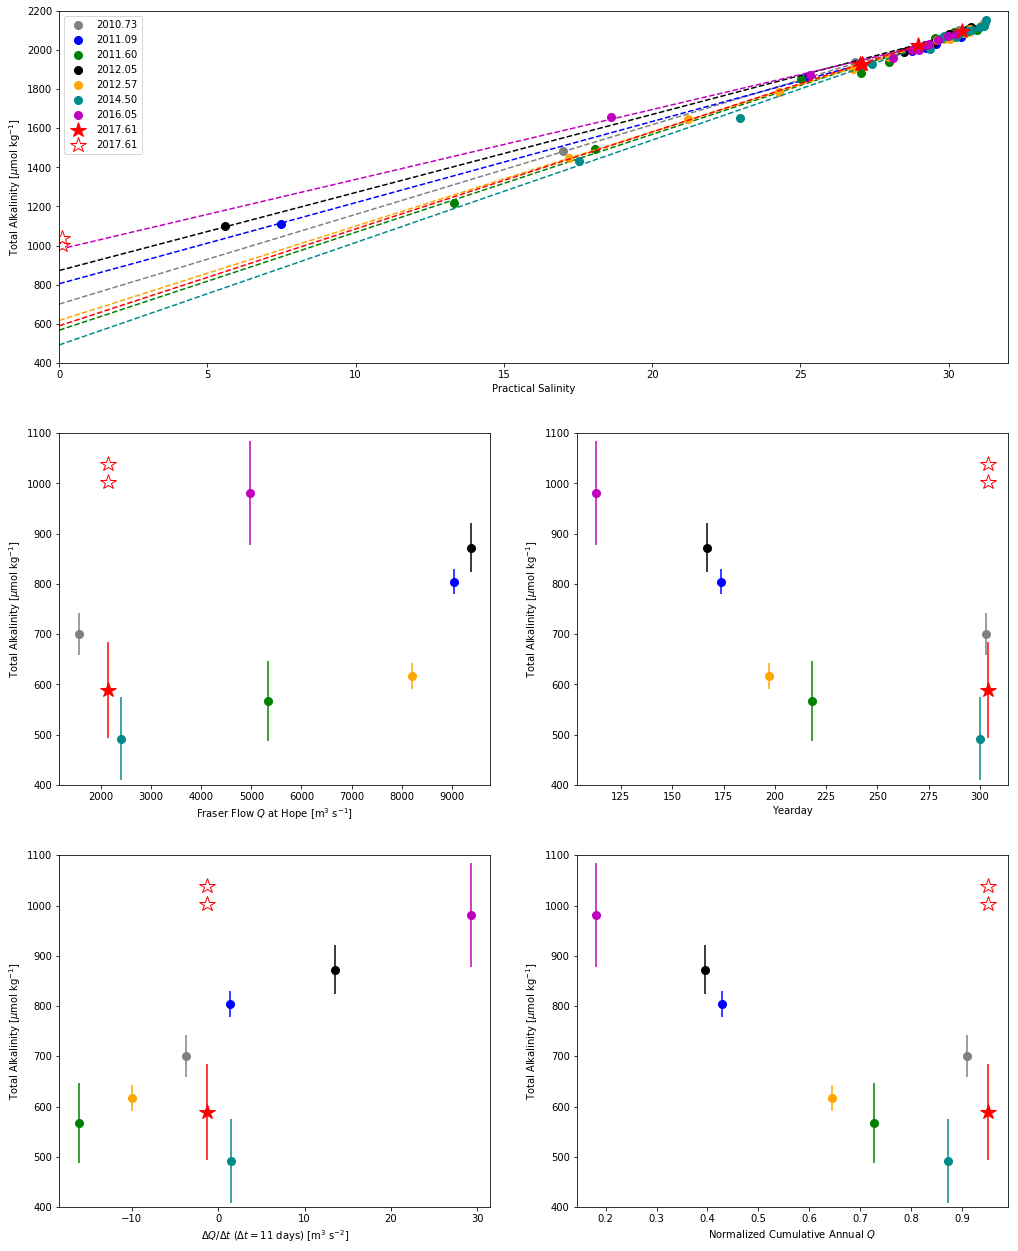

In [5]:
# Cruises to plot
cruises = [2010.73, 2011.09, 2011.60, 2012.05, 2012.57, 2014.50, 2016.05, 2017.61, 2017.61]
stations = [39.5, 42., 39.5, 42., 39.5, 42., 42., 1.5, 0.5]
colors = ['gray', 'b', 'g', 'k', 'orange', 'darkcyan', 'm', 'r', 'r']

# Make figure
fig = plt.figure(figsize=(17, 22))
gs = gridspec.GridSpec(3, 2)
axs = [fig.add_subplot(gs[0, :])]
axs.extend([fig.add_subplot(gs[1, col]) for col in range(2)])
axs.extend([fig.add_subplot(gs[2, col]) for col in range(2)])

# Loop through cruises
for cruise, station, color, flow in zip(cruises, stations, colors, flows):
    
    # Symbols
    if color is 'r':
        marker = '*'
        size = 16
    else:
        marker = 'o'
        size = 8
    
    # Index
    index = (crid == cruise) & (stn == station) & ((alk_qf == 2) | (alk_qf == 6))
    
    # Regressions
    if station == 0.5:
        facecolor = 'w'
    else:
        facecolor = color
        model = sm.OLS(alk[index], sm.add_constant(S[index])).fit()
    
    # Flow metrics
    W2 = 5
    flowindex = abs(np.array(dates) - datetime(int(cruise), int(mnth[index][0]), int(day[index][0]))).argmin()
    yearstart = abs(np.array(dates) - datetime(int(cruise), 1, 1)).argmin()
    yearend = abs(np.array(dates) - datetime(int(cruise), 12, 31)).argmin()
    dQdt = np.diff(flows[flowindex-W2: flowindex+W2]).mean()/len(flows[flowindex-W2: flowindex+W2])
    intQ = flows[yearstart:flowindex].sum()/flows[yearstart:yearend].sum()
    
    # Salinity Regression Plot
    axs[0].plot(
        S[index], alk[index],
        marker=marker, color=color,
        markersize=size, markerfacecolor=facecolor,
        linestyle='', label=f'{cruise:.2f}',
    )
    if station != 0.5:
        axs[0].plot(np.arange(30), model.params[1] * np.arange(30) + model.params[0], linestyle='--', color=color)
    axs[0].set_xlim([0, 32])
    axs[0].set_ylim([400, 2200])
    axs[0].set_xlabel('Practical Salinity')
    axs[0].set_ylabel('Total Alkalinity [$\mu$mol kg$^{-1}$]')
    
    # Endmember Plots
    metrics = [flows[flowindex], (dates[flowindex] - dates[yearstart]).days, dQdt, intQ]
    labels = [
        'Fraser Flow $Q$ at Hope [m$^3$ s$^{-1}$]',
        'Yearday',
        '$\Delta Q/\Delta t$ ($\Delta t = 11$ days) [m$^{3}$ s$^{-2}$]',
        'Normalized Cumulative Annual $Q$',
    ]
    for ax, x, label in zip(axs[1:], metrics, labels):
        if station == 0.5:
            ax.plot(
                x*np.ones(sum(index)), alk[index],
                marker=marker, color=color,
                markerfacecolor=facecolor, markersize=size, linestyle='',
            )
        else:
            ax.plot(x, model.params[0], marker=marker, color=color, markerfacecolor=facecolor, markersize=size)
            ax.errorbar(x, model.params[0], model.conf_int()[0][1] - model.params[0], color=color)
        ax.set_ylim([400, 1100])
        ax.set_xlabel(label)
        ax.set_ylabel('Total Alkalinity [$\mu$mol kg$^{-1}$]')

axs[0].legend()
plt.show()